In [1]:
import os
import pandas as pd
import numpy as np
import math
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.stats import shapiro
from scipy.stats import zscore
from scipy.stats import levene
from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import probplot
from distfit import distfit

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
original_data = pd.read_csv('survey_results.csv', index_col=0)

# original_data

In [4]:
original_df = df = pd.DataFrame(original_data) 

In [5]:
original_df['id'].value_counts(normalize=True)

ffadb36b-5051-4684-b9cf-ed767a599434    0.013409
e52573b2-d900-486a-8a2e-55b5ff069846    0.013409
c50b7807-e77a-423f-bfe2-249f600a6498    0.013409
40acd98a-cd00-46b7-a727-4b10379241d7    0.013409
d0fe44d9-8816-4aea-99f8-a613c4c74fde    0.013409
                                          ...   
b1db6112-8144-433e-98c2-a89f1c5516d7    0.012913
02f10e19-83e5-48a3-be35-5258e2e89c1a    0.012913
1cf1d8ae-0e92-44c7-b3e2-488adfd0c537    0.012665
51f28cc5-797e-489a-b4f3-545e47dec783    0.012665
aaaac871-71b8-4180-a4fb-8028260c9bd5    0.012665
Name: id, Length: 76, dtype: float64

## Split by assigned group (A/B)

In [6]:
group_A = original_df[original_df['group'] == "A"]
group_A['network_enc'] = group_A['question'].str.split('_').str[0]
group_A['task_type'] = group_A['question'].str.split('_').str[1]
group_A['task_entity'] = group_A['question'].str.split('_').str[2]
group_A['temporal_enc'] = group_A['question'].str.split('_').str[3]
group_A['correct'] = group_A['correct'].apply(str).str.lower()
# group_A = group_A.drop(['group', 'question', 'id'], axis='columns')

len(group_A['id'].unique())

18

In [7]:
group_B = original_df[original_df['group'] == "B"]

group_B['network_enc'] = group_B['question'].str.split('_').str[0]
group_B['task_type'] = group_B['question'].str.split('_').str[1]
group_B['task_entity'] = group_B['question'].str.split('_').str[2]
group_B['temporal_enc'] = group_B['question'].str.split('_').str[3]
group_B['correct'] = group_B['correct'].apply(str).str.lower()
# group_B = group_B.drop(['group', 'question', 'id'], axis='columns')

len(group_B['id'].unique())

58

In [8]:
group_A.to_csv('group_A', sep=";")
group_B.to_csv('group_B', sep=";")

## Control Questions

In [9]:
group_A_control = group_A.loc[group_A['question'].str.contains('control')]
group_A_control_false = group_A_control.loc[group_A_control['correct'] == 'false']
group_A_control_false

,group,id,question,answer,time,confidence,correct_answer,correct,zoom_timers,drag_timers,...,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc
1549,A,479e65b9-b9d6-4d01-bb8e-ba919e769fa7,control1,green,41,2,red,false,[],[],...,0,0,0,31,0,0,control1,NaN,NaN,NaN
3614,A,f357cda5-2402-4fd5-93ff-d8d6ed2a566d,control1,yellow,101,2,red,false,[],[],...,0,0,0,0,0,1,control1,NaN,NaN,NaN
3642,A,f357cda5-2402-4fd5-93ff-d8d6ed2a566d,control3,AD37,189,3,LT02,false,[],[],...,0,0,0,0,0,2,control3,NaN,NaN,NaN


In [10]:
group_B_control = group_B.loc[group_B['question'].str.contains('control')]
group_B_control_false = group_B_control.loc[group_B_control['correct'] == 'false']
group_B_control_false

,group,id,question,answer,time,confidence,correct_answer,correct,zoom_timers,drag_timers,...,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc
145,B,037605fd-b893-4885-b04a-8e9c2bed8a1a,control3,VZ38,17,5,LT02,false,[1204],[],...,1,0,21,0,1,0,control3,NaN,NaN,NaN
223,B,0d215911-e63c-46ad-a063-653b709f8253,control1,yellow,306,1,red,false,"[152, 153, 508, 152]",[],...,4,0,0,0,0,3,control1,NaN,NaN,NaN
251,B,0d215911-e63c-46ad-a063-653b709f8253,control3,AD37,139,1,LT02,false,"[265, 151, 907, 152, 151, 957, 152, 2297, 1696...",[],...,22,0,87,0,0,4,control3,NaN,NaN,NaN
383,B,1039ad57-5293-4af8-acce-89edd244cc7a,control1,yellow,40,5,red,false,"[165, 165, 499, 333, 154, 230, 237]",[],...,7,0,27,0,0,31,control1,NaN,NaN,NaN
912,B,224c8817-b026-4280-b546-04d6cb5388f7,control1,green,45,1,red,false,"[158, 244, 449, 230, 151, 151, 548, 675, 635, ...","[85, 3463, 3227]",...,10,3,0,7,0,0,control1,NaN,NaN,NaN
940,B,224c8817-b026-4280-b546-04d6cb5388f7,control3,DO54,122,1,LT02,false,"[153, 160, 1600, 484]",[3412],...,4,1,0,0,0,2,control3,NaN,NaN,NaN
1046,B,2e4f721a-71de-465c-97c1-4bd8a4c7a5d4,control3,VZ38,43,5,LT02,false,"[159, 160, 259, 1597, 193, 902, 218, 151, 807]",[],...,9,0,0,0,0,0,control3,NaN,NaN,NaN
1497,B,40ec582a-987a-4135-af15-2c273b27ae87,control1,black,9,1,red,false,"[205, 275, 464, 565]","[400, 4947]",...,4,2,0,0,0,0,control1,NaN,NaN,NaN
2127,B,78b9a69e-7ab0-4c26-bb02-21125956bd0a,control1,black,29,1,red,false,[],[],...,0,0,5,0,0,3,control1,NaN,NaN,NaN
2180,B,86bfd834-db2c-44ee-8300-8f182be02533,control1,green,96,1,red,false,"[154, 262, 302]",[],...,3,0,1,4,0,0,control1,NaN,NaN,NaN


In [11]:
group_B_control_false['id'].unique()

array(['037605fd-b893-4885-b04a-8e9c2bed8a1a',
       '0d215911-e63c-46ad-a063-653b709f8253',
       '1039ad57-5293-4af8-acce-89edd244cc7a',
       '224c8817-b026-4280-b546-04d6cb5388f7',
       '2e4f721a-71de-465c-97c1-4bd8a4c7a5d4',
       '40ec582a-987a-4135-af15-2c273b27ae87',
       '78b9a69e-7ab0-4c26-bb02-21125956bd0a',
       '86bfd834-db2c-44ee-8300-8f182be02533',
       'b998c460-ce32-4abf-a6c8-d96caf7284c9',
       'c50b7807-e77a-423f-bfe2-249f600a6498',
       'd5d47990-2fbb-4eed-b467-f49476866cd0',
       'e207e91b-f772-486c-bc7e-8ad924a50598',
       'f7d50be8-6102-4e5c-abf2-b5a05bc1c168',
       'f81817ac-49cb-47ed-a599-6b9ba011360d',
       'ffadb36b-5051-4684-b9cf-ed767a599434'], dtype=object)

In [ ]:
# Grp B:
# (mostly true)
# 0d215911-e63c-46ad-a063-653b709f8253
# 037605fd-b893-4885-b04a-8e9c2bed8a1a

# (mostly false)
# 1039ad57-5293-4af8-acce-89edd244cc7a
# 86bfd834-db2c-44ee-8300-8f182be02533

# 224c8817-b026-4280-b546-04d6cb5388f7
# 2e4f721a-71de-465c-97c1-4bd8a4c7a5d4
# ffadb36b-5051-4684-b9cf-ed767a599434

# Grp A:
# f357cda5-2402-4fd5-93ff-d8d6ed2a566d

## Split group by task type (T1/T2/T3)

### A

In [12]:
group_A_T1 = group_A[group_A['question'].str.contains('T1', case=False)]
# group_A_T1

In [13]:
group_A_T2 = group_A[group_A['question'].str.contains('T2', case=False)]
# group_A_T2

In [14]:
group_A_T3 = group_A[group_A['question'].str.contains('T3', case=False)]
# group_A_T3

### B

In [15]:
group_B_T1 = group_B[group_B['question'].str.contains('T1', case=False)]
# group_B_T1

In [16]:
group_B_T2 = group_B[group_B['question'].str.contains('T2', case=False)]
# group_B_T2

In [17]:
group_B_T3 = group_B[group_B['question'].str.contains('T3', case=False)]
# group_B_T3

## Split by network representation 

### Node-Link A+B

In [18]:
group_A_T1_NL = group_A_T1[group_A_T1['question'].str.contains('nl_', case=False)]
group_A_T1_NL['temporal_enc'] = group_A_T1_NL['question'].str.upper().str[-2:]
# group_A_T1_NL

In [19]:
group_A_T2_NL = group_A_T2[group_A_T2['question'].str.contains('nl_', case=False)]
group_A_T2_NL['temporal_enc'] = group_A_T2_NL['question'].str.upper().str[-2:]
# group_A_T2_NL

In [20]:
group_A_T3_NL = group_A_T3[group_A_T3['question'].str.contains('nl_', case=False)]
group_A_T3_NL['temporal_enc'] = group_A_T3_NL['question'].str.upper().str[-2:]
# group_A_T3_NL

In [21]:
group_B_T1_NL = group_B_T1[group_B_T1['question'].str.contains('nl_', case=False)]
group_B_T1_NL['temporal_enc'] = group_B_T1_NL['question'].str.upper().str[-2:]
# group_B_T1_NL

In [22]:
group_B_T2_NL = group_B_T2[group_B_T2['question'].str.contains('nl_', case=False)]
group_B_T2_NL['temporal_enc'] = group_B_T2_NL['question'].str.upper().str[-2:]
# group_B_T2_NL

In [23]:
group_B_T3_NL = group_B_T3[group_B_T3['question'].str.contains('nl_', case=False)]
group_B_T3_NL['temporal_enc'] = group_B_T3_NL['question'].str.upper().str[-2:]
# group_B_T3_NL

### Matrix A+B

In [24]:
group_A_T1_M = group_A_T1[group_A_T1['question'].str.contains('m_', case=False)]
group_A_T1_M['temporal_enc'] = group_A_T1_M['question'].str.upper().str[-2:]
# group_A_T1_M

In [25]:
group_A_T2_M = group_A_T2[group_A_T2['question'].str.contains('m_', case=False)]
group_A_T2_M['temporal_enc'] = group_A_T2_M['question'].str.upper().str[-2:]
# group_A_T2_M

In [26]:
group_A_T3_M = group_A_T3[group_A_T3['question'].str.contains('m_', case=False)]
group_A_T3_M['temporal_enc'] = group_A_T3_M['question'].str.upper().str[-2:]
# group_A_T3_M

In [27]:
group_B_T1_M = group_B_T1[group_B_T1['question'].str.contains('m_', case=False)]
group_B_T1_M['temporal_enc'] = group_B_T1_M['question'].str.upper().str[-2:]
# group_B_T1_M

In [28]:
group_B_T2_M = group_B_T2[group_B_T2['question'].str.contains('m_', case=False)]
group_B_T2_M['temporal_enc'] = group_B_T2_M['question'].str.upper().str[-2:]
# group_B_T2_M

In [29]:
group_B_T3_M = group_B_T3[group_B_T3['question'].str.contains('m_', case=False)]
group_B_T3_M['temporal_enc'] = group_B_T3_M['question'].str.upper().str[-2:]
# group_B_T3_M

## Bar and Whiskers Plots

[Text(0.5, 1.0, 'M T3')]

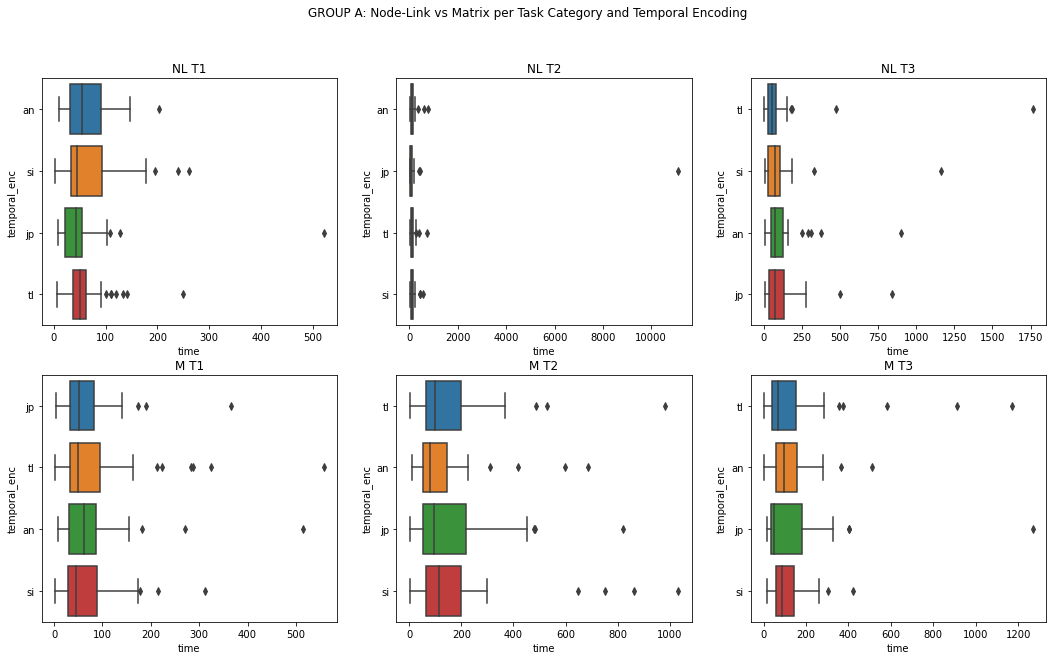

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('GROUP A: Node-Link vs Matrix per Task Category and Temporal Encoding')

sns.boxplot(ax=axes[0, 0], data=group_A[(group_A['network_enc'] == 'nl') & (group_A['task_type'] == 't1')], x='time', y='temporal_enc').set(title='NL T1')
sns.boxplot(ax=axes[0, 1], data=group_A[(group_A['network_enc'] == 'nl') & (group_A['task_type'] == 't2')], x='time', y='temporal_enc').set(title='NL T2')
sns.boxplot(ax=axes[0, 2], data=group_A[(group_A['network_enc'] == 'nl') & (group_A['task_type'] == 't3')], x='time', y='temporal_enc').set(title='NL T3')
sns.boxplot(ax=axes[1, 0], data=group_A[(group_A['network_enc'] == 'm') & (group_A['task_type'] == 't1')], x='time', y='temporal_enc').set(title='M T1')
sns.boxplot(ax=axes[1, 1], data=group_A[(group_A['network_enc'] == 'm') & (group_A['task_type'] == 't2')], x='time', y='temporal_enc').set(title='M T2')
sns.boxplot(ax=axes[1, 2], data=group_A[(group_A['network_enc'] == 'm') & (group_A['task_type'] == 't3')], x='time', y='temporal_enc').set(title='M T3')

[Text(0.5, 1.0, 'M T3')]

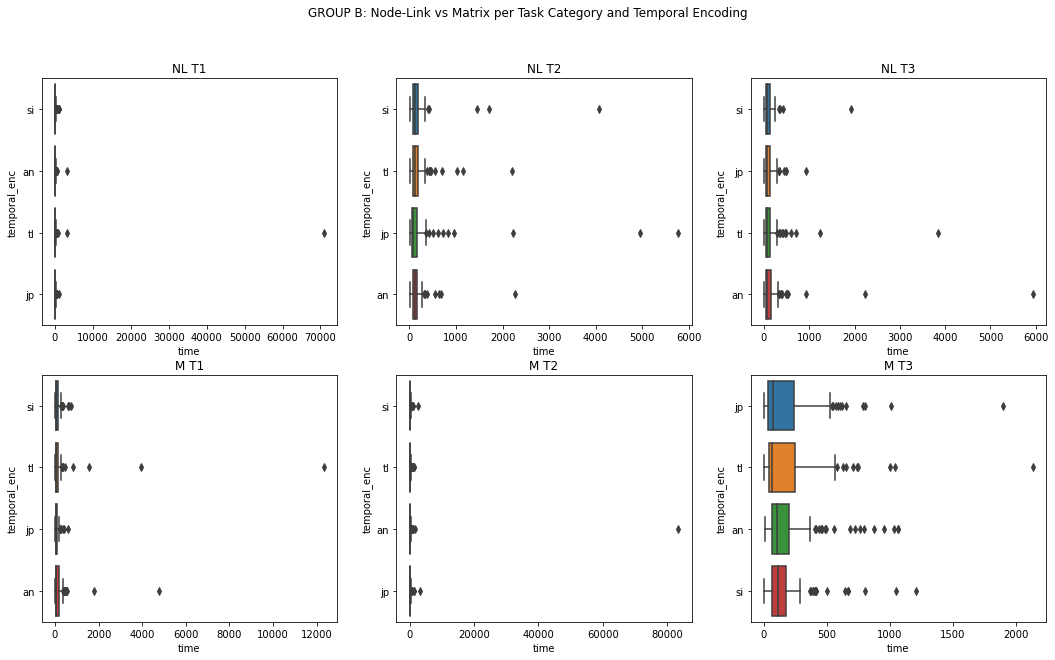

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('GROUP B: Node-Link vs Matrix per Task Category and Temporal Encoding')

sns.boxplot(ax=axes[0, 0], data=group_B[(group_B['network_enc'] == 'nl') & (group_B['task_type'] == 't1')], x='time', y='temporal_enc').set(title='NL T1')
sns.boxplot(ax=axes[0, 1], data=group_B[(group_B['network_enc'] == 'nl') & (group_B['task_type'] == 't2')], x='time', y='temporal_enc').set(title='NL T2')
sns.boxplot(ax=axes[0, 2], data=group_B[(group_B['network_enc'] == 'nl') & (group_B['task_type'] == 't3')], x='time', y='temporal_enc').set(title='NL T3')
sns.boxplot(ax=axes[1, 0], data=group_B[(group_B['network_enc'] == 'm') & (group_B['task_type'] == 't1')], x='time', y='temporal_enc').set(title='M T1')
sns.boxplot(ax=axes[1, 1], data=group_B[(group_B['network_enc'] == 'm') & (group_B['task_type'] == 't2')], x='time', y='temporal_enc').set(title='M T2')
sns.boxplot(ax=axes[1, 2], data=group_B[(group_B['network_enc'] == 'm') & (group_B['task_type'] == 't3')], x='time', y='temporal_enc').set(title='M T3')

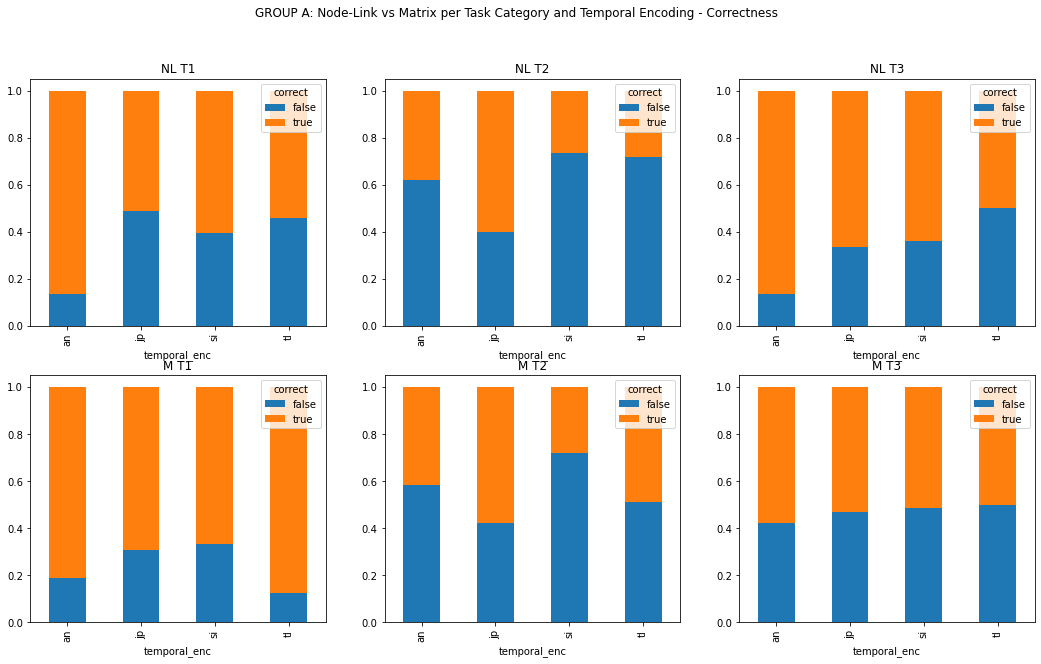

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('GROUP A: Node-Link vs Matrix per Task Category and Temporal Encoding - Correctness')

df1 = group_A[(group_A['network_enc'] == 'nl') & (group_A['task_type'] == 't1')]
df2 = group_A[(group_A['network_enc'] == 'nl') & (group_A['task_type'] == 't2')]
df3 = group_A[(group_A['network_enc'] == 'nl') & (group_A['task_type'] == 't3')]
df4 = group_A[(group_A['network_enc'] == 'm') & (group_A['task_type'] == 't1')]
df5 = group_A[(group_A['network_enc'] == 'm') & (group_A['task_type'] == 't2')]
df6 = group_A[(group_A['network_enc'] == 'm') & (group_A['task_type'] == 't3')]

df_list = [df1 ,df2, df3, df4, df5, df6]
titles = ['NL T1', 'NL T2', 'NL T3', 'M T1', 'M T2', 'M T3']

# plot counter
count=0
for r in range(2):
    for c in range(3):
        pd.crosstab(df_list[count]['temporal_enc'], df_list[count]['correct'], normalize="index").plot(ax=axes[r,c], kind="bar",stacked=True).set(title=titles[count])
        count+=1

In [33]:
df1['question'].value_counts()

nl_t1_single_jp    20
nl_t1_single_si    19
nl_t1_clique_jp    19
nl_t1_clique_si    19
nl_t1_clique_an    19
nl_t1_single_an    18
nl_t1_single_tl    18
nl_t1_clique_tl    17
Name: question, dtype: int64

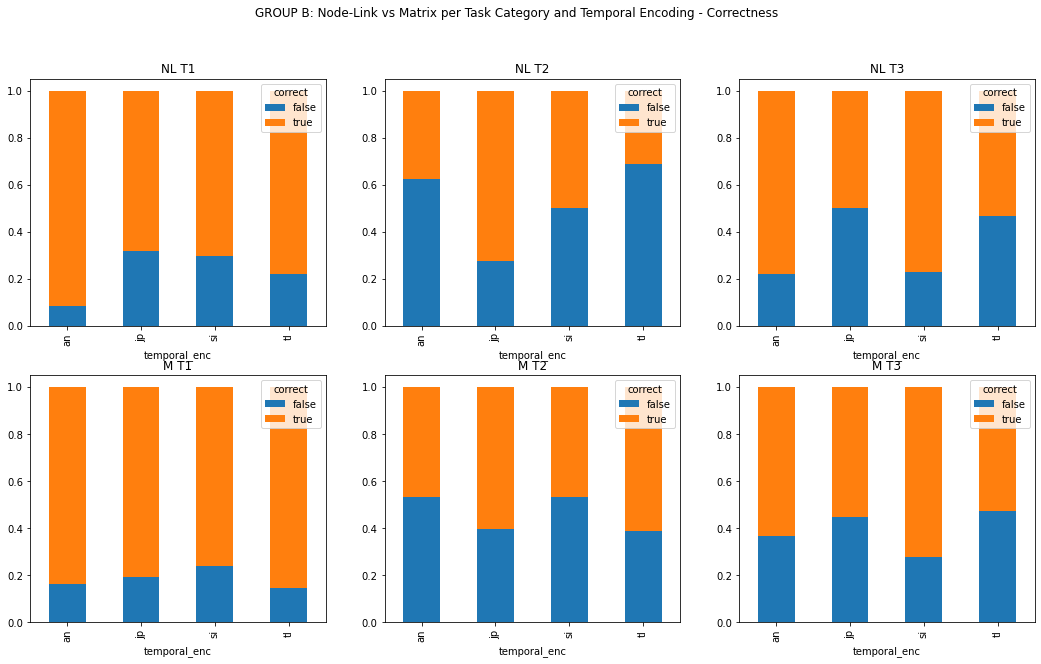

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('GROUP B: Node-Link vs Matrix per Task Category and Temporal Encoding - Correctness')

df1 = group_B[(group_B['network_enc'] == 'nl') & (group_B['task_type'] == 't1')]
df2 = group_B[(group_B['network_enc'] == 'nl') & (group_B['task_type'] == 't2')]
df3 = group_B[(group_B['network_enc'] == 'nl') & (group_B['task_type'] == 't3')]
df4 = group_B[(group_B['network_enc'] == 'm') & (group_B['task_type'] == 't1')]
df5 = group_B[(group_B['network_enc'] == 'm') & (group_B['task_type'] == 't2')]
df6 = group_B[(group_B['network_enc'] == 'm') & (group_B['task_type'] == 't3')]

df_list = [df1 ,df2, df3, df4, df5, df6]
titles = ['NL T1', 'NL T2', 'NL T3', 'M T1', 'M T2', 'M T3']

# plot counter
count=0
for r in range(2):
    for c in range(3):
        pd.crosstab(df_list[count]['temporal_enc'], df_list[count]['correct'], normalize="index").plot(ax=axes[r,c], kind="bar",stacked=True).set(title=titles[count])
        count+=1

In [35]:
df1['question'].value_counts()

nl_t1_single_tl    63
nl_t1_clique_jp    63
nl_t1_single_si    60
nl_t1_single_an    60
nl_t1_single_jp    60
nl_t1_clique_tl    60
nl_t1_clique_an    58
nl_t1_clique_si    58
Name: question, dtype: int64

## Normality Tests

In [36]:
%%script false

# GRP A NL
group_A_T1_NL_time = group_A_T1_NL['time'] # Not normally distributed
group_A_T1_NL_correctness = group_A_T1_NL['correct'] 
group_A_T1_NL_confidence = group_A_T1_NL['confidence'] # Not normally distributed
group_A_T1_NL_answers = group_A_T1_NL['answer'] # Not normally distributed

group_A_T2_NL_time = group_A_T2_NL['time'] # Not normally distributed
group_A_T2_NL_correctness = group_A_T2_NL['correct']
group_A_T2_NL_confidence = group_A_T2_NL['confidence'] # Not normally distributed
group_A_T2_NL_answers = group_A_T2_NL['answer'] # Not normally distributed

group_A_T3_NL_time = group_A_T3_NL['time'] # Not normally distributed
group_A_T3_NL_correctness = group_A_T3_NL['correct'] 
group_A_T3_NL_confidence = group_A_T3_NL['confidence'] # Not normally distributed
group_A_T3_NL_answers = group_A_T3_NL['answer'] # Not normally distributed

# GRP A M
group_A_T1_M_time = group_A_T1_NL['time'] # Not normally distributed
group_A_T1_M_correctness = group_A_T1_M['correct'] 
group_A_T1_M_confidence = group_A_T1_M['confidence'] # Not normally distributed
group_A_T1_M_answers = group_A_T1_M['answer'] # Not normally distributed

group_A_T2_M_time = group_A_T2_M['time'] # Not normally distributed
group_A_T2_M_correctness = group_A_T2_M['correct']
group_A_T2_M_confidence = group_A_T2_M['confidence'] # Not normally distributed
group_A_T2_M_answers = group_A_T2_M['answer'] # Not normally distributed

group_A_T3_M_time = group_A_T3_M['time'] # Not normally distributed
group_A_T3_M_correctness = group_A_T3_M['correct'] 
group_A_T3_M_confidence = group_A_T3_M['confidence'] # Not normally distributed
group_A_T3_M_answers = group_A_T3_M['answer'] # Not normally distributed

# GRP B NL
group_B_T1_NL_time = group_B_T1_NL['time'] # Not normally distributed
group_B_T1_NL_correctness = group_B_T1_NL['correct']
group_B_T1_NL_confidence = group_B_T1_NL['confidence'] # Not normally distributed
group_B_T1_NL_answers = group_B_T1_NL['answer'] # Not normally distributed

group_B_T2_NL_time = group_B_T2_NL['time'] # Not normally distributed
group_B_T2_NL_correctness = group_B_T2_NL['correct']
group_B_T2_NL_confidence = group_B_T2_NL['confidence'] # Not normally distributed
group_B_T2_NL_answers = group_B_T2_NL['answer'] # Not normally distributed

group_B_T3_NL_time = group_B_T3_NL['time'] # Not normally distributed
group_B_T3_NL_correctness = group_B_T3_NL['correct']
group_B_T3_NL_confidence = group_B_T3_NL['confidence'] # Not normally distributed
group_B_T3_NL_answers = group_B_T3_NL['answer'] # Not normally distributed

#GRP B M
group_B_T1_M_time = group_B_T1_NL['time'] # Not normally distributed 
group_B_T1_M_correctness = group_B_T1_M['correct']
group_B_T1_M_confidence = group_B_T1_M['confidence'] # Not normally distributed
group_B_T1_M_answers = group_B_T1_M['answer'] # Not normally distributed

group_B_T2_M_time = group_B_T2_M['time'] # Not normally distributed
group_B_T2_M_correctness = group_B_T2_M['correct']
group_B_T2_M_confidence = group_B_T2_M['confidence'] # Not normally distributed
group_B_T2_M_answers = group_B_T2_M['answer'] # Not normally distributed

group_B_T3_M_time = group_B_T3_M['time'] # Not normally distributed
group_B_T3_M_correctness = group_B_T3_M['correct']
group_B_T3_M_confidence = group_B_T3_M['confidence'] # Not normally distributed
group_B_T3_M_answers = group_B_T3_M['answer'] # Not normally distributed


Couldn't find program: 'false'


## Outlier removal

In [37]:
def remove_outliers(df, col, lower_perc, higher_perc):
    for x in [col]:
        # Np.percentile uses a normal distribution
        # check parameters for skewed distributions (https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) 
        # normalize before and match to a distribution using mean/variance/std 
        q75,q25 = np.percentile(df.loc[:,x],[higher_perc,lower_perc])
        intr_qr = q75-q25

        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)

        df.loc[df[x] < min,x] = np.nan
        df.loc[df[x] > max,x] = np.nan
        
        df.isnull().sum()
        df = df.dropna(axis = 0)
    return df

In [38]:
%%script false

# GRP A NL
group_A_T1_NL_cleaned = remove_outliers(group_A_T1_NL, 'time', 25, 75)
group_A_T1_NL_cleaned = remove_outliers(group_A_T1_NL, 'time', 25, 75)
group_A_T1_NL_cleaned = remove_outliers(group_A_T1_NL, 'time', 25, 75)

group_A_T2_NL_cleaned = remove_outliers(group_A_T2_NL, 'time', 25, 75)
group_A_T2_NL_cleaned = remove_outliers(group_A_T2_NL, 'time', 25, 75)
group_A_T2_NL_cleaned = remove_outliers(group_A_T2_NL, 'time', 25, 75)

group_A_T3_NL_cleaned = remove_outliers(group_A_T3_NL, 'time', 25, 75)
group_A_T3_NL_cleaned = remove_outliers(group_A_T3_NL, 'time', 25, 75)
group_A_T3_NL_cleaned = remove_outliers(group_A_T3_NL, 'time', 25, 75)

# GRP A M
group_A_T1_M_cleaned = remove_outliers(group_A_T1_M, 'time', 25, 75)
group_A_T1_M_cleaned = remove_outliers(group_A_T1_M, 'time', 25, 75)
group_A_T1_M_cleaned = remove_outliers(group_A_T1_M, 'time', 25, 75)

group_A_T2_M_cleaned = remove_outliers(group_A_T2_M, 'time', 25, 75)
group_A_T2_M_cleaned = remove_outliers(group_A_T2_M, 'time', 25, 75)
group_A_T2_M_cleaned = remove_outliers(group_A_T2_M, 'time', 25, 75)

group_A_T3_M_cleaned = remove_outliers(group_A_T3_M, 'time', 25, 75)
group_A_T3_M_cleaned = remove_outliers(group_A_T3_M, 'time', 25, 75)
group_A_T3_M_cleaned = remove_outliers(group_A_T3_M, 'time', 25, 75)

# GRP B NL
group_B_T1_NL_cleaned = remove_outliers(group_B_T1_NL, 'time', 25, 75)
group_B_T1_NL_cleaned = remove_outliers(group_B_T1_NL, 'time', 25, 75)
group_B_T1_NL_cleaned = remove_outliers(group_B_T1_NL, 'time', 25, 75)

group_B_T2_NL_cleaned = remove_outliers(group_B_T2_NL, 'time', 25, 75)
group_B_T2_NL_cleaned = remove_outliers(group_B_T2_NL, 'time', 25, 75)
group_B_T2_NL_cleaned = remove_outliers(group_B_T2_NL, 'time', 25, 75)

group_B_T3_NL_cleaned = remove_outliers(group_B_T3_NL, 'time', 25, 75)
group_B_T3_NL_cleaned = remove_outliers(group_B_T3_NL, 'time', 25, 75)
group_B_T3_NL_cleaned = remove_outliers(group_B_T3_NL, 'time', 25, 75)

# GRP B M
group_B_T1_M_cleaned = remove_outliers(group_B_T1_M, 'time', 25, 75)
group_B_T1_M_cleaned = remove_outliers(group_B_T1_M, 'time', 25, 75)
group_B_T1_M_cleaned = remove_outliers(group_B_T1_M, 'time', 25, 75)

group_B_T2_M_cleaned = remove_outliers(group_B_T2_M, 'time', 25, 75)
group_B_T2_M_cleaned = remove_outliers(group_B_T2_M, 'time', 25, 75)
group_B_T2_M_cleaned = remove_outliers(group_B_T2_M, 'time', 25, 75)

group_B_T3_M_cleaned = remove_outliers(group_B_T3_M, 'time', 25, 75)
group_B_T3_M_cleaned = remove_outliers(group_B_T3_M, 'time', 25, 75)
group_B_T3_M_cleaned = remove_outliers(group_B_T3_M, 'time', 25, 75)

Couldn't find program: 'false'


### Histograms

In [39]:
def plot_hist(data):
    pyplot.hist(data)

In [40]:
%%script false
plot_hist(group_A_T3_NL_cleaned['time'])

Couldn't find program: 'false'


In [41]:
%%script false
plot_hist(group_A_T3_NL_time)

Couldn't find program: 'false'


In [42]:
%%script false
plot_hist(group_B_T3_M_cleaned['answer'])

Couldn't find program: 'false'


In [43]:
%%script false
plot_hist(group_B_T3_M_cleaned['correct'])

Couldn't find program: 'false'


In [44]:
%%script false
plot_hist(group_B_T3_M_cleaned['confidence'])

Couldn't find program: 'false'


### Shapiro-Wilk Test

In [45]:
def shapiro_wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [46]:
%%script false
shapiro_wilk(group_B_T3_M_cleaned['time'])

Couldn't find program: 'false'


In [47]:
%%script false
shapiro_wilk(group_B_T3_M_cleaned['confidence'])

Couldn't find program: 'false'


In [48]:
%%script false
shapiro_wilk(group_B_T3_M_cleaned['answer'])

Couldn't find program: 'false'


## Homogeneity Tests

In [49]:
# not normally distributed data so use Levene's test 
# https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/

In [50]:
def levene_test(arr1, arr2, arr3, arr4, center):
    stat, p = levene(arr1, arr2, arr3, arr4, center=center)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

In [51]:
%%script false

# GRP A NL
grp_A_NL_T1_JP = group_A_T1_NL_cleaned[group_A_T1_NL_cleaned['temporal_enc']=='JP']['time']
grp_A_NL_T1_SI = group_A_T1_NL_cleaned[group_A_T1_NL_cleaned['temporal_enc']=='SI']['time']
grp_A_NL_T1_AN = group_A_T1_NL_cleaned[group_A_T1_NL_cleaned['temporal_enc']=='AN']['time']
grp_A_NL_T1_TL = group_A_T1_NL_cleaned[group_A_T1_NL_cleaned['temporal_enc']=='TL']['time']

grp_A_NL_T2_JP = group_A_T2_NL_cleaned[group_A_T2_NL_cleaned['temporal_enc']=='JP']['time']
grp_A_NL_T2_SI = group_A_T2_NL_cleaned[group_A_T2_NL_cleaned['temporal_enc']=='SI']['time']
grp_A_NL_T2_AN = group_A_T2_NL_cleaned[group_A_T2_NL_cleaned['temporal_enc']=='AN']['time']
grp_A_NL_T2_TL = group_A_T2_NL_cleaned[group_A_T2_NL_cleaned['temporal_enc']=='TL']['time']

grp_A_NL_T3_JP = group_A_T3_NL_cleaned[group_A_T3_NL_cleaned['temporal_enc']=='JP']['time']
grp_A_NL_T3_SI = group_A_T3_NL_cleaned[group_A_T3_NL_cleaned['temporal_enc']=='SI']['time']
grp_A_NL_T3_AN = group_A_T3_NL_cleaned[group_A_T3_NL_cleaned['temporal_enc']=='AN']['time']
grp_A_NL_T3_TL = group_A_T3_NL_cleaned[group_A_T3_NL_cleaned['temporal_enc']=='TL']['time']

# GRP A M
grp_A_M_T1_JP = group_A_T1_M_cleaned[group_A_T1_M_cleaned['temporal_enc']=='JP']['time']
grp_A_M_T1_SI = group_A_T1_M_cleaned[group_A_T1_M_cleaned['temporal_enc']=='SI']['time']
grp_A_M_T1_AN = group_A_T1_M_cleaned[group_A_T1_M_cleaned['temporal_enc']=='AN']['time']
grp_A_M_T1_TL = group_A_T1_M_cleaned[group_A_T1_M_cleaned['temporal_enc']=='TL']['time']

grp_A_M_T2_JP = group_A_T2_M_cleaned[group_A_T2_M_cleaned['temporal_enc']=='JP']['time']
grp_A_M_T2_SI = group_A_T2_M_cleaned[group_A_T2_M_cleaned['temporal_enc']=='SI']['time']
grp_A_M_T2_AN = group_A_T2_M_cleaned[group_A_T2_M_cleaned['temporal_enc']=='AN']['time']
grp_A_M_T2_TL = group_A_T2_M_cleaned[group_A_T2_M_cleaned['temporal_enc']=='TL']['time']

grp_A_M_T3_JP = group_A_T3_M_cleaned[group_A_T3_M_cleaned['temporal_enc']=='JP']['time']
grp_A_M_T3_SI = group_A_T3_M_cleaned[group_A_T3_M_cleaned['temporal_enc']=='SI']['time']
grp_A_M_T3_AN = group_A_T3_M_cleaned[group_A_T3_M_cleaned['temporal_enc']=='AN']['time']
grp_A_M_T3_TL = group_A_T3_M_cleaned[group_A_T3_M_cleaned['temporal_enc']=='TL']['time']

# GRP B NL
grp_B_NL_T1_JP = group_B_T1_NL_cleaned[group_B_T1_NL_cleaned['temporal_enc']=='JP']['time']
grp_B_NL_T1_SI = group_B_T1_NL_cleaned[group_B_T1_NL_cleaned['temporal_enc']=='SI']['time']
grp_B_NL_T1_AN = group_B_T1_NL_cleaned[group_B_T1_NL_cleaned['temporal_enc']=='AN']['time']
grp_B_NL_T1_TL = group_B_T1_NL_cleaned[group_B_T1_NL_cleaned['temporal_enc']=='TL']['time']

grp_B_NL_T2_JP = group_B_T2_NL_cleaned[group_B_T2_NL_cleaned['temporal_enc']=='JP']['time']
grp_B_NL_T2_SI = group_B_T2_NL_cleaned[group_B_T2_NL_cleaned['temporal_enc']=='SI']['time']
grp_B_NL_T2_AN = group_B_T2_NL_cleaned[group_B_T2_NL_cleaned['temporal_enc']=='AN']['time']
grp_B_NL_T2_TL = group_B_T2_NL_cleaned[group_B_T2_NL_cleaned['temporal_enc']=='TL']['time']

grp_B_NL_T3_JP = group_B_T3_NL_cleaned[group_B_T3_NL_cleaned['temporal_enc']=='JP']['time']
grp_B_NL_T3_SI = group_B_T3_NL_cleaned[group_B_T3_NL_cleaned['temporal_enc']=='SI']['time']
grp_B_NL_T3_AN = group_B_T3_NL_cleaned[group_B_T3_NL_cleaned['temporal_enc']=='AN']['time']
grp_B_NL_T3_TL = group_B_T3_NL_cleaned[group_B_T3_NL_cleaned['temporal_enc']=='TL']['time']

# GRP A M
grp_B_M_T1_JP = group_B_T1_M_cleaned[group_B_T1_M_cleaned['temporal_enc']=='JP']['time']
grp_B_M_T1_SI = group_B_T1_M_cleaned[group_B_T1_M_cleaned['temporal_enc']=='SI']['time']
grp_B_M_T1_AN = group_B_T1_M_cleaned[group_B_T1_M_cleaned['temporal_enc']=='AN']['time']
grp_B_M_T1_TL = group_B_T1_M_cleaned[group_B_T1_M_cleaned['temporal_enc']=='TL']['time']

grp_B_M_T2_JP = group_B_T2_M_cleaned[group_B_T2_M_cleaned['temporal_enc']=='JP']['time']
grp_B_M_T2_SI = group_B_T2_M_cleaned[group_B_T2_M_cleaned['temporal_enc']=='SI']['time']
grp_B_M_T2_AN = group_B_T2_M_cleaned[group_B_T2_M_cleaned['temporal_enc']=='AN']['time']
grp_B_M_T2_TL = group_B_T2_M_cleaned[group_B_T2_M_cleaned['temporal_enc']=='TL']['time']

grp_B_M_T3_JP = group_B_T3_M_cleaned[group_B_T3_M_cleaned['temporal_enc']=='JP']['time']
grp_B_M_T3_SI = group_B_T3_M_cleaned[group_B_T3_M_cleaned['temporal_enc']=='SI']['time']
grp_B_M_T3_AN = group_B_T3_M_cleaned[group_B_T3_M_cleaned['temporal_enc']=='AN']['time']
grp_B_M_T3_TL = group_B_T3_M_cleaned[group_B_T3_M_cleaned['temporal_enc']=='TL']['time']

Couldn't find program: 'false'


### Group A (NL and M - all tasks)

In [52]:
%%script false
levene_test(grp_A_NL_T1_JP, grp_A_NL_T1_SI, grp_A_NL_T1_AN, grp_A_NL_T1_TL, 'trimmed')

Couldn't find program: 'false'


In [53]:
%%script false
levene_test(grp_A_NL_T2_JP, grp_A_NL_T2_SI, grp_A_NL_T2_AN, grp_A_NL_T2_TL, 'median')

Couldn't find program: 'false'


In [54]:
%%script false
levene_test(grp_A_NL_T3_JP, grp_A_NL_T3_SI, grp_A_NL_T3_AN, grp_A_NL_T3_TL, 'median')

Couldn't find program: 'false'


In [55]:
%%script false
levene_test(grp_A_M_T1_JP, grp_A_M_T1_SI, grp_A_M_T1_AN, grp_A_M_T1_TL, 'median')

Couldn't find program: 'false'


In [56]:
%%script false
levene_test(grp_A_M_T2_JP, grp_A_M_T2_SI, grp_A_M_T2_AN, grp_A_M_T2_TL, 'median')

Couldn't find program: 'false'


In [57]:
%%script false
levene_test(grp_A_M_T3_JP, grp_A_M_T3_SI, grp_A_M_T3_AN, grp_A_M_T3_TL, 'median')

Couldn't find program: 'false'


### Group B (NL and M - all tasks)

In [58]:
%%script false
levene_test(grp_B_NL_T1_JP, grp_B_NL_T1_SI, grp_B_NL_T1_AN, grp_B_NL_T1_TL, 'median')

Couldn't find program: 'false'


In [59]:
%%script false
levene_test(grp_B_NL_T2_JP, grp_B_NL_T2_SI, grp_B_NL_T2_AN, grp_B_NL_T2_TL, 'median')

Couldn't find program: 'false'


In [60]:
%%script false
levene_test(grp_B_NL_T3_JP, grp_B_NL_T3_SI, grp_B_NL_T3_AN, grp_B_NL_T3_TL, 'median')

Couldn't find program: 'false'


In [61]:
%%script false
levene_test(grp_B_M_T1_JP, grp_B_M_T1_SI, grp_B_M_T1_AN, grp_B_M_T1_TL, 'median')

Couldn't find program: 'false'


In [62]:
%%script false
levene_test(grp_B_M_T2_JP, grp_B_M_T2_SI, grp_B_M_T2_AN, grp_B_M_T2_TL, 'median')

Couldn't find program: 'false'


In [63]:
%%script false
levene_test(grp_B_M_T3_JP, grp_B_M_T3_SI, grp_B_M_T3_AN, grp_B_M_T3_TL, 'median')

Couldn't find program: 'false'


## Distribution Fitting

In [64]:
def test_distribution(time_orig, time_trans):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    prob = probplot(time_orig, dist=norm, plot=ax1)
    prob = probplot(time_trans, dist=norm, plot=ax2)

    ax1.set_title('Original Data')
    ax1.set_ylabel('Time Taken')
    ax2.set_title('Transforamed Data, λ = %s' % -0.322);
    ax2.set_ylabel('');

In [65]:
def box_cox(df):
    df_trans, lmbda = boxcox(df)
    return df_trans

In [66]:
def remove_outlier_IQR(df, lower, upper):
    Q1=df.quantile(lower/100)
    Q3=df.quantile(upper/100)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

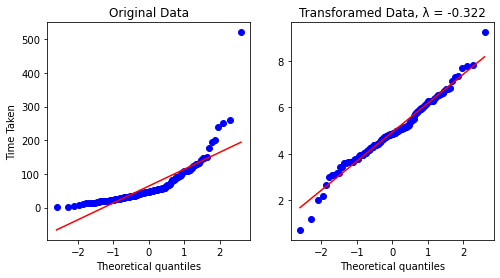

In [67]:
grp_A_T1_NL_time = group_A_T1_NL['time']
grp_A_T1_NL_time_trans = box_cox(grp_A_T1_NL_time)
test_distribution(grp_A_T1_NL_time, grp_A_T1_NL_time_trans)

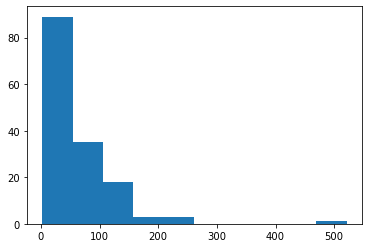

In [68]:
plot_hist(grp_A_T1_NL_time)

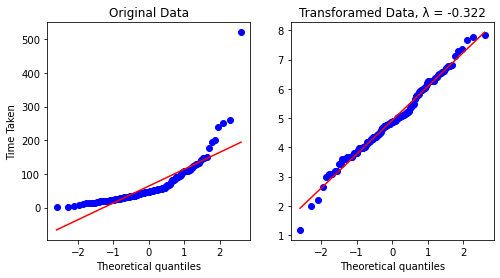

In [176]:
grp_A_T1_NL_time = group_A_T1_NL['time']
grp_A_T1_NL_time_trans = box_cox(grp_A_T1_NL_time)
grp_A_T1_NL_time_trans_rem = remove_outlier_IQR(pd.Series(grp_A_T1_NL_time_trans), 20, 80)
test_distribution(grp_A_T1_NL_time, grp_A_T1_NL_time_trans_rem)

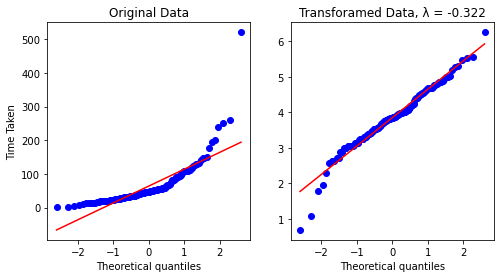

In [206]:
grp_A_T1_NL_time_sqrd = np.log(group_A_T1_NL['time'])
test_distribution(grp_A_T1_NL_time, grp_A_T1_NL_time_sqrd)

In [167]:
grp_A_T1_NL_time

273      44
274      67
287      47
293      26
295      37
       ... 
3940    260
3941     42
3942     49
3947     35
3965    202
Name: time, Length: 149, dtype: int64

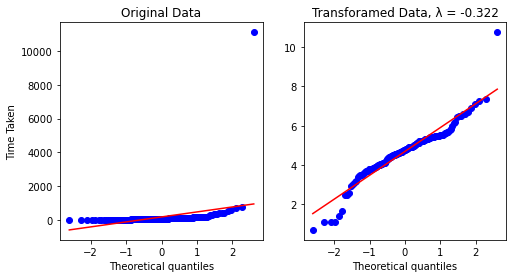

In [70]:
grp_A_T2_NL_time = group_A_T2_NL['time']
grp_A_T2_NL_time_trans = box_cox(grp_A_T2_NL_time)
test_distribution(grp_A_T2_NL_time, grp_A_T2_NL_time_trans)

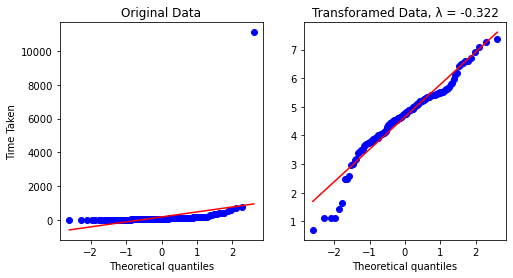

In [180]:
grp_A_T2_NL_time = group_A_T2_NL['time']
grp_A_T2_NL_time_trans = box_cox(grp_A_T2_NL_time)
grp_A_T2_NL_time_trans_rem = remove_outlier_IQR(pd.Series(grp_A_T2_NL_time_trans), 10, 90)
test_distribution(grp_A_T2_NL_time, grp_A_T2_NL_time_trans_rem)

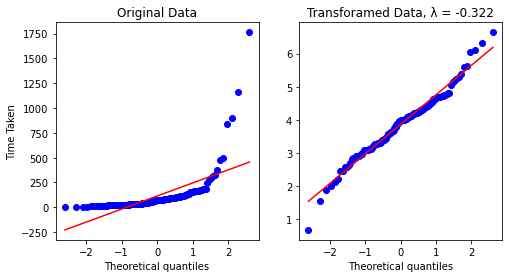

In [72]:
grp_A_T3_NL_time = group_A_T3_NL['time']
grp_A_T3_NL_time_trans = box_cox(grp_A_T3_NL_time)
test_distribution(grp_A_T3_NL_time, grp_A_T3_NL_time_trans)

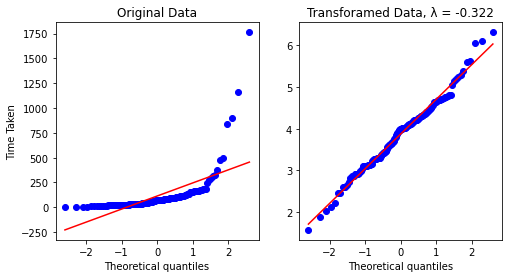

In [184]:
grp_A_T3_NL_time = group_A_T3_NL['time']
grp_A_T3_NL_time_trans = box_cox(grp_A_T3_NL_time)
grp_A_T3_NL_time_trans_rem = remove_outlier_IQR(pd.Series(grp_A_T3_NL_time_trans), 20, 80)
test_distribution(grp_A_T3_NL_time, grp_A_T3_NL_time_trans_rem)

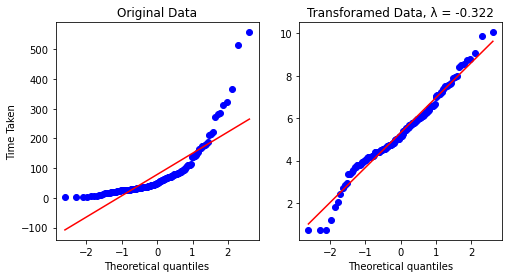

In [74]:
grp_A_T1_M_time = group_A_T1_M['time']
grp_A_T1_M_time_trans = box_cox(grp_A_T1_M_time)
test_distribution(grp_A_T1_M_time, grp_A_T1_M_time_trans)

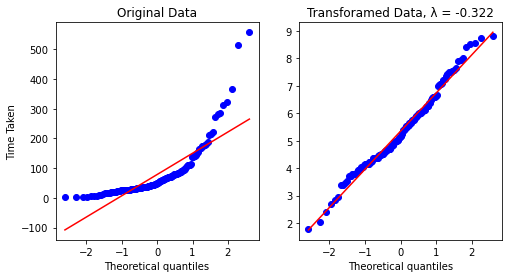

In [75]:
grp_A_T1_M_time = group_A_T1_M['time']
grp_A_T1_M_time_trans = box_cox(grp_A_T1_M_time)
grp_A_T1_M_time_trans_rem = remove_outlier_IQR(pd.Series(grp_A_T1_M_time_trans), 25, 75)
test_distribution(grp_A_T1_M_time, grp_A_T1_M_time_trans_rem)

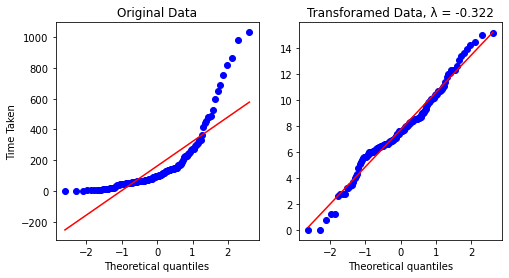

In [76]:
grp_A_T2_M_time = group_A_T2_M['time']
grp_A_T2_M_time_trans = box_cox(grp_A_T2_M_time)
test_distribution(grp_A_T2_M_time, grp_A_T2_M_time_trans)

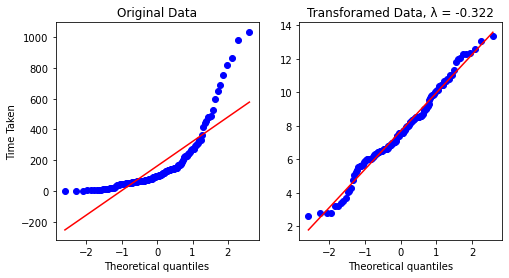

In [77]:
grp_A_T2_M_time = group_A_T2_M['time']
grp_A_T2_M_time_trans = box_cox(grp_A_T2_M_time)
grp_A_T2_M_time_trans_rem = remove_outlier_IQR(pd.Series(grp_A_T2_M_time_trans), 25, 75)
test_distribution(grp_A_T2_M_time, grp_A_T2_M_time_trans_rem)

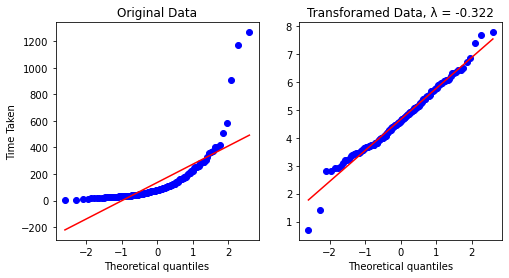

In [78]:
grp_A_T3_M_time = group_A_T3_M['time']
grp_A_T3_M_time_trans = box_cox(grp_A_T3_M_time)
test_distribution(grp_A_T3_M_time, grp_A_T3_M_time_trans)

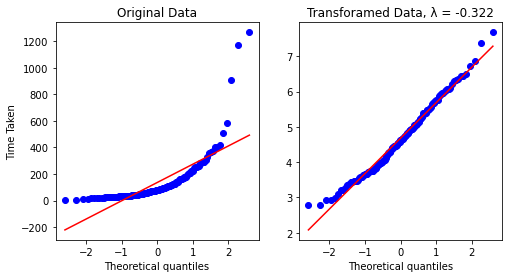

In [186]:
grp_A_T3_M_time = group_A_T3_M['time']
grp_A_T3_M_time_trans = box_cox(grp_A_T3_M_time)
grp_A_T3_M_time_trans_rem = remove_outlier_IQR(pd.Series(grp_A_T3_M_time_trans), 25, 75)
test_distribution(grp_A_T3_M_time, grp_A_T3_M_time_trans_rem)

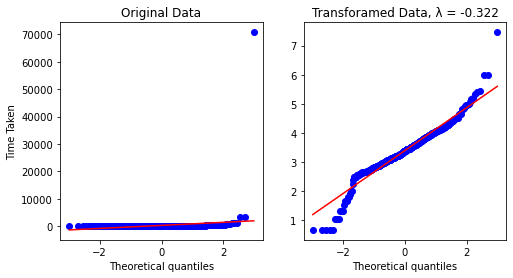

In [80]:
grp_B_T1_NL_time = group_B_T1_NL['time']
grp_B_T1_NL_time_trans = box_cox(grp_B_T1_NL_time)
test_distribution(grp_B_T1_NL_time, grp_B_T1_NL_time_trans)

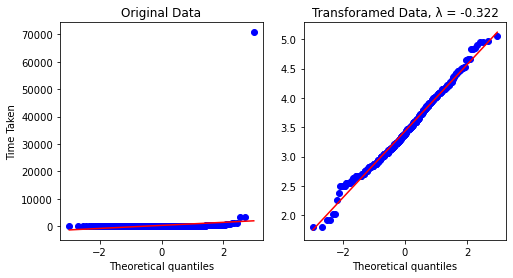

In [198]:
grp_B_T1_NL_time = group_B_T1_NL['time']
grp_B_T1_NL_time_trans = box_cox(grp_B_T1_NL_time)
grp_B_T1_NL_time_trans_rem = remove_outlier_IQR(pd.Series(grp_B_T1_NL_time_trans), 25, 75)
test_distribution(grp_B_T1_NL_time, grp_B_T1_NL_time_trans_rem)

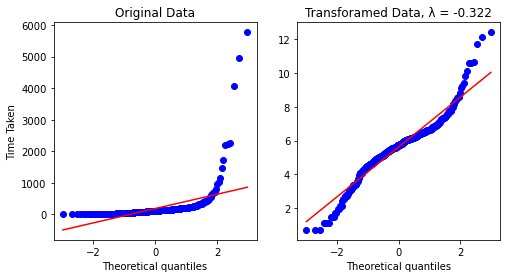

In [82]:
grp_B_T2_NL_time = group_B_T2_NL['time']
grp_B_T2_NL_time_trans = box_cox(grp_B_T2_NL_time)
test_distribution(grp_B_T2_NL_time, grp_B_T2_NL_time_trans)

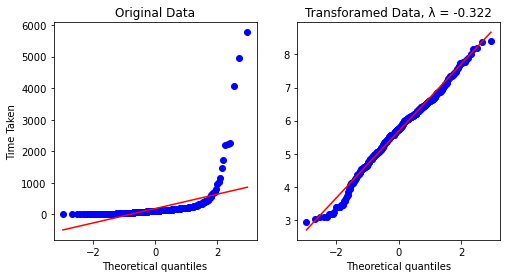

In [83]:
grp_B_T2_NL_time = group_B_T2_NL['time']
grp_B_T2_NL_time_trans = box_cox(grp_B_T2_NL_time)
grp_B_T2_NL_time_trans_rem = remove_outlier_IQR(pd.Series(grp_B_T2_NL_time_trans), 25, 75)
test_distribution(grp_B_T2_NL_time, grp_B_T2_NL_time_trans_rem)

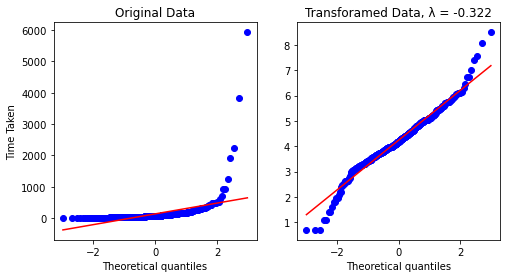

In [84]:
grp_B_T3_NL_time = group_B_T3_NL['time']
grp_B_T3_NL_time_trans = box_cox(grp_B_T3_NL_time)
test_distribution(grp_B_T3_NL_time, grp_B_T3_NL_time_trans)

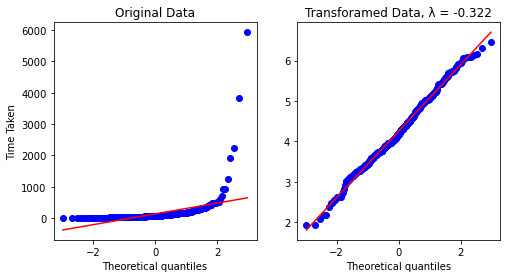

In [85]:
grp_B_T3_NL_time = group_B_T3_NL['time']
grp_B_T3_NL_time_trans = box_cox(grp_B_T3_NL_time)
grp_B_T3_NL_time_trans_rem = remove_outlier_IQR(pd.Series(grp_B_T3_NL_time_trans), 25, 75)
test_distribution(grp_B_T3_NL_time, grp_B_T3_NL_time_trans_rem)

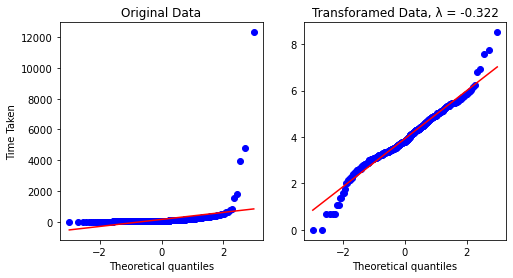

In [86]:
grp_B_T1_M_time = group_B_T1_M['time']
grp_B_T1_M_time_trans = box_cox(grp_B_T1_M_time)
test_distribution(grp_B_T1_M_time, grp_B_T1_M_time_trans)

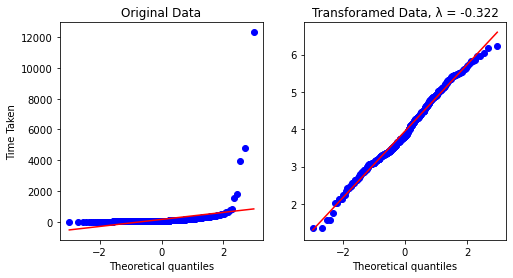

In [87]:
grp_B_T1_M_time = group_B_T1_M['time']
grp_B_T1_M_time_trans = box_cox(grp_B_T1_M_time)
grp_B_T1_M_time_trans_rem = remove_outlier_IQR(pd.Series(grp_B_T1_M_time_trans), 25, 75)
test_distribution(grp_B_T1_M_time, grp_B_T1_M_time_trans_rem)

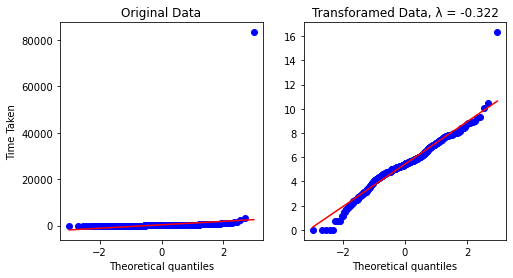

In [88]:
grp_B_T2_M_time = group_B_T2_M['time']
grp_B_T2_M_time_trans = box_cox(grp_B_T2_M_time)
test_distribution(grp_B_T2_M_time, grp_B_T2_M_time_trans)

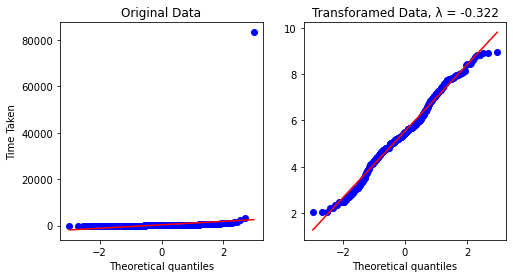

In [157]:
grp_B_T2_M_time = group_B_T2_M['time']
grp_B_T2_M_time_trans = box_cox(grp_B_T2_M_time)
grp_B_T2_M_time_trans_rem = remove_outlier_IQR(pd.Series(grp_B_T2_M_time_trans), 25, 75)
test_distribution(grp_B_T2_M_time, grp_B_T2_M_time_trans_rem)

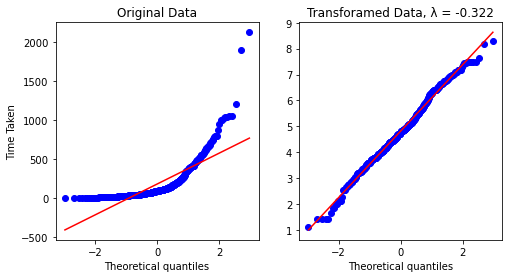

In [90]:
grp_B_T3_M_time = group_B_T3_M['time']
grp_B_T3_M_time_trans = box_cox(grp_B_T3_M_time)
test_distribution(grp_B_T3_M_time, grp_B_T3_M_time_trans)

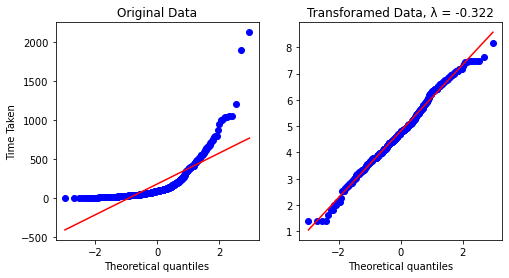

In [91]:
grp_B_T3_M_time = group_B_T3_M['time']
grp_B_T3_M_time_trans = box_cox(grp_B_T3_M_time)
grp_B_T3_M_time_trans_rem = remove_outlier_IQR(pd.Series(grp_B_T3_M_time_trans), 25, 75)
test_distribution(grp_B_T3_M_time, grp_B_T3_M_time_trans_rem)

## Shapiro Wilk Test for double checking normality of transformation

In [171]:
shapiro_wilk(grp_A_T1_NL_time_trans)

Statistics=0.980, p=0.030
Sample does not look Gaussian (reject H0)


In [172]:
shapiro_wilk(grp_A_T1_NL_time_trans_rem)

Statistics=0.980, p=0.030
Sample does not look Gaussian (reject H0)


<AxesSubplot:>

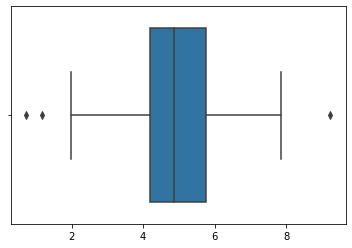

In [173]:
sns.boxplot(grp_A_T1_NL_time_trans)

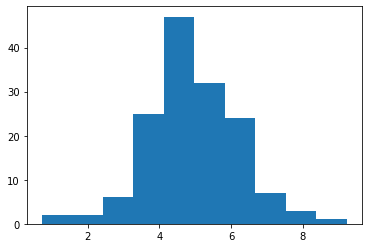

In [169]:
plot_hist(grp_A_T1_NL_time_trans)

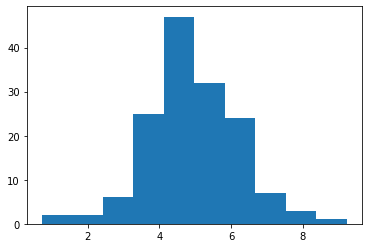

In [170]:
plot_hist(grp_A_T1_NL_time_trans_rem)

In [96]:
shapiro_wilk(grp_A_T2_NL_time_trans)

Statistics=0.923, p=0.000
Sample does not look Gaussian (reject H0)


In [97]:
shapiro_wilk(grp_A_T2_NL_time_trans_rem)

Statistics=0.987, p=0.228
Sample looks Gaussian (fail to reject H0)


<AxesSubplot:>

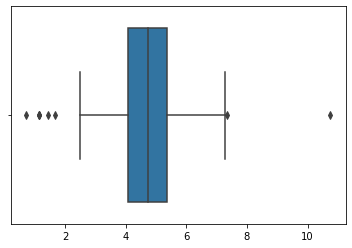

In [141]:
sns.boxplot(grp_A_T2_NL_time_trans)

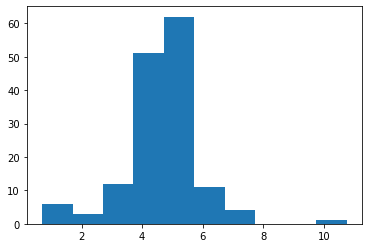

In [98]:
plot_hist(grp_A_T2_NL_time_trans)

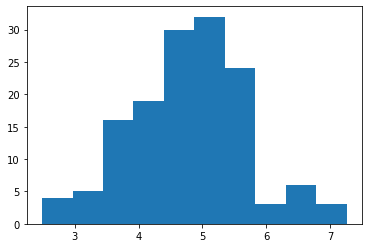

In [99]:
plot_hist(grp_A_T2_NL_time_trans_rem)

In [100]:
shapiro_wilk(grp_A_T3_NL_time_trans)

Statistics=0.982, p=0.042
Sample does not look Gaussian (reject H0)


In [101]:
shapiro_wilk(grp_A_T3_NL_time_trans_rem)

Statistics=0.991, p=0.501
Sample looks Gaussian (fail to reject H0)


<AxesSubplot:>

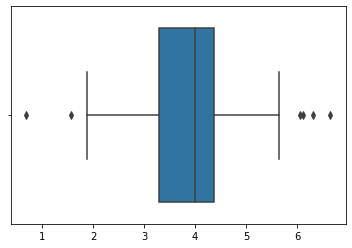

In [142]:
sns.boxplot(grp_A_T3_NL_time_trans)

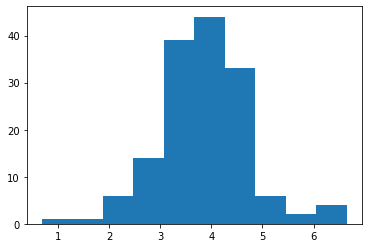

In [102]:
plot_hist(grp_A_T3_NL_time_trans)

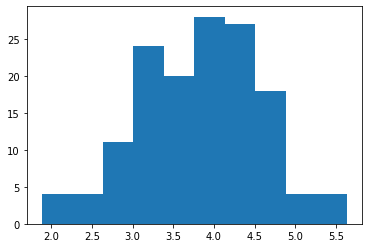

In [103]:
plot_hist(grp_A_T3_NL_time_trans_rem)

In [104]:
shapiro_wilk(grp_A_T1_M_time_trans)

Statistics=0.977, p=0.011
Sample does not look Gaussian (reject H0)


In [105]:
shapiro_wilk(grp_A_T1_M_time_trans_rem)

Statistics=0.984, p=0.097
Sample looks Gaussian (fail to reject H0)


<AxesSubplot:>

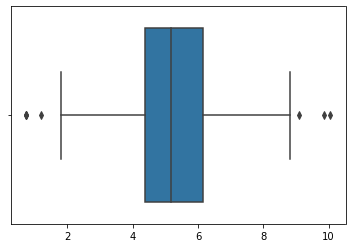

In [143]:
sns.boxplot(grp_A_T1_M_time_trans)

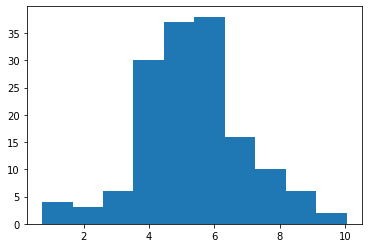

In [106]:
plot_hist(grp_A_T1_M_time_trans)

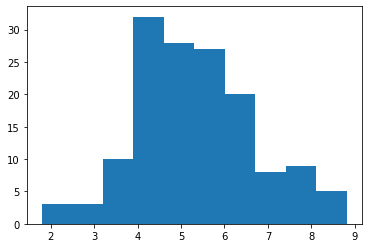

In [107]:
plot_hist(grp_A_T1_M_time_trans_rem)

In [108]:
shapiro_wilk(grp_A_T2_M_time_trans)

Statistics=0.978, p=0.015
Sample does not look Gaussian (reject H0)


In [109]:
shapiro_wilk(grp_A_T2_M_time_trans_rem)

Statistics=0.983, p=0.077
Sample looks Gaussian (fail to reject H0)


<AxesSubplot:>

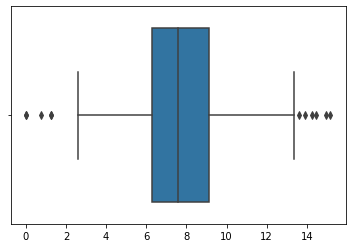

In [146]:
sns.boxplot(grp_A_T2_M_time_trans)

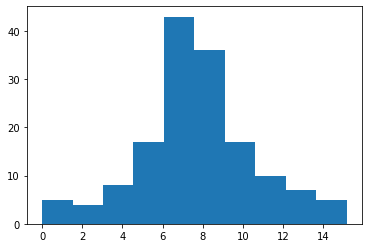

In [144]:
plot_hist(grp_A_T2_M_time_trans)

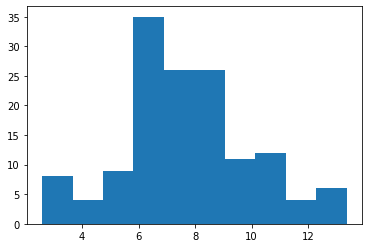

In [145]:
plot_hist(grp_A_T2_M_time_trans_rem)

In [112]:
shapiro_wilk(grp_A_T3_M_time_trans)

Statistics=0.984, p=0.081
Sample looks Gaussian (fail to reject H0)


In [147]:
shapiro_wilk(grp_A_T3_M_time_trans_rem)

Statistics=0.983, p=0.064
Sample looks Gaussian (fail to reject H0)


<AxesSubplot:>

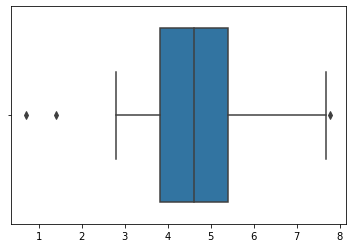

In [148]:
sns.boxplot(grp_A_T3_M_time_trans)

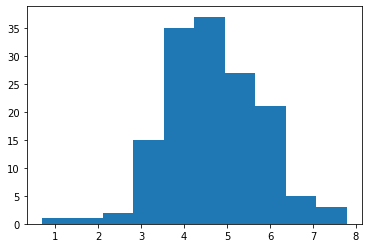

In [149]:
plot_hist(grp_A_T3_M_time_trans)

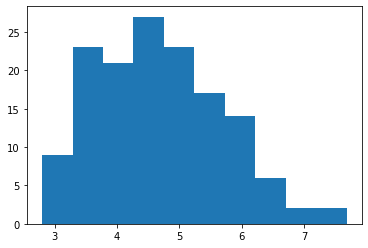

In [150]:
plot_hist(grp_A_T3_M_time_trans_rem)

In [192]:
shapiro_wilk(grp_B_T1_NL_time_trans)

Statistics=0.944, p=0.000
Sample does not look Gaussian (reject H0)


In [200]:
shapiro_wilk(grp_B_T1_NL_time_trans_rem)

Statistics=0.991, p=0.008
Sample does not look Gaussian (reject H0)


<AxesSubplot:>

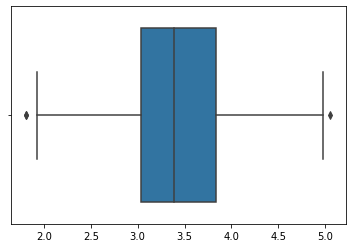

In [199]:
sns.boxplot(grp_B_T1_NL_time_trans_rem)

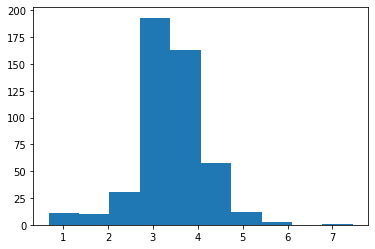

In [195]:
plot_hist(grp_B_T1_NL_time_trans)

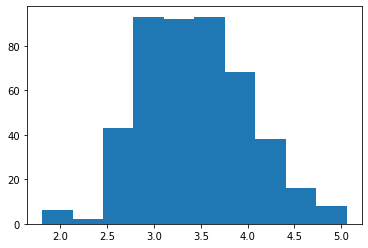

In [196]:
plot_hist(grp_B_T1_NL_time_trans_rem)

In [116]:
shapiro_wilk(grp_B_T2_NL_time_trans)

Statistics=0.935, p=0.000
Sample does not look Gaussian (reject H0)


In [117]:
shapiro_wilk(grp_B_T2_NL_time_trans_rem)

Statistics=0.989, p=0.002
Sample does not look Gaussian (reject H0)


<AxesSubplot:>

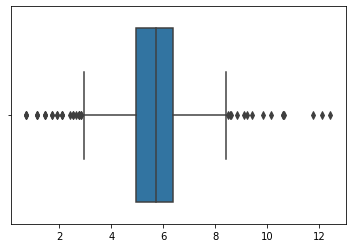

In [153]:
sns.boxplot(grp_B_T2_NL_time_trans)

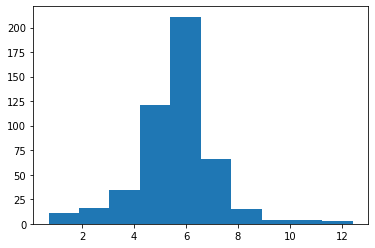

In [118]:
plot_hist(grp_B_T2_NL_time_trans)

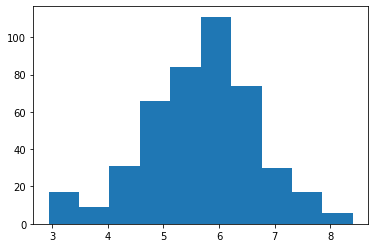

In [119]:
plot_hist(grp_B_T2_NL_time_trans_rem)

In [120]:
shapiro_wilk(grp_B_T3_NL_time_trans)

Statistics=0.972, p=0.000
Sample does not look Gaussian (reject H0)


In [121]:
shapiro_wilk(grp_B_T3_NL_time_trans_rem)

Statistics=0.995, p=0.091
Sample looks Gaussian (fail to reject H0)


<AxesSubplot:>

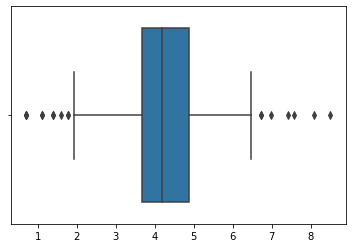

In [154]:
sns.boxplot(grp_B_T3_NL_time_trans)

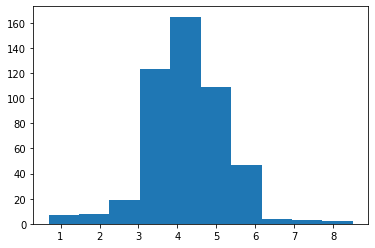

In [122]:
plot_hist(grp_B_T3_NL_time_trans)

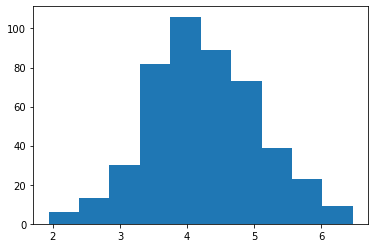

In [123]:
plot_hist(grp_B_T3_NL_time_trans_rem)

In [124]:
shapiro_wilk(grp_B_T1_M_time_trans)

Statistics=0.973, p=0.000
Sample does not look Gaussian (reject H0)


In [125]:
shapiro_wilk(grp_B_T1_M_time_trans_rem)

Statistics=0.991, p=0.004
Sample does not look Gaussian (reject H0)


<AxesSubplot:>

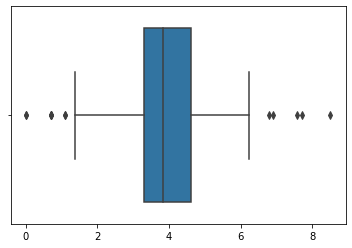

In [158]:
sns.boxplot(grp_B_T1_M_time_trans)

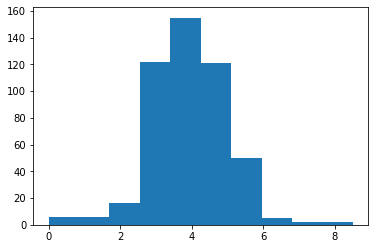

In [126]:
plot_hist(grp_B_T1_M_time_trans)

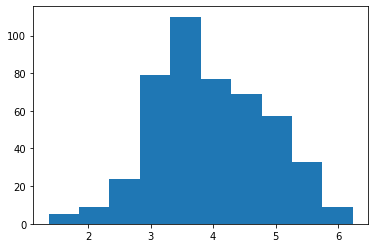

In [127]:
plot_hist(grp_B_T1_M_time_trans_rem)

In [160]:
shapiro_wilk(grp_B_T2_M_time_trans)

Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


In [161]:
shapiro_wilk(grp_B_T2_M_time_trans_rem)

Statistics=0.988, p=0.001
Sample does not look Gaussian (reject H0)


<AxesSubplot:>

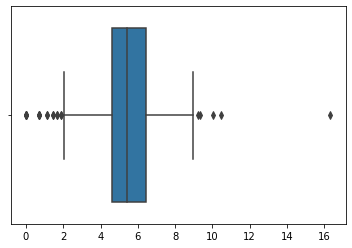

In [159]:
sns.boxplot(grp_B_T2_M_time_trans)

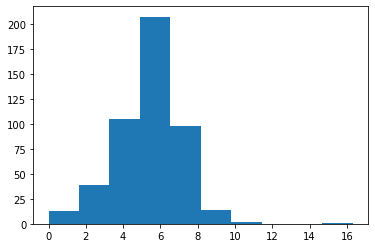

In [162]:
plot_hist(grp_B_T2_M_time_trans)

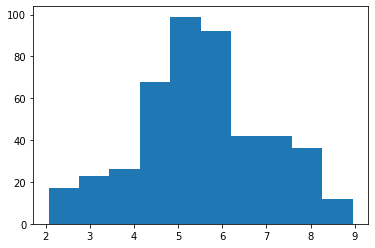

In [163]:
plot_hist(grp_B_T2_M_time_trans_rem)

In [132]:
shapiro_wilk(grp_B_T3_M_time_trans)

Statistics=0.994, p=0.043
Sample does not look Gaussian (reject H0)


In [133]:
shapiro_wilk(grp_B_T3_M_time_trans_rem)

Statistics=0.993, p=0.019
Sample does not look Gaussian (reject H0)


<AxesSubplot:>

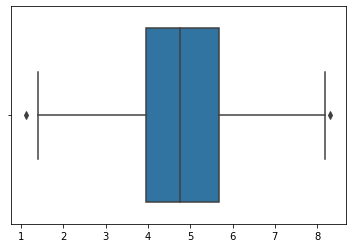

In [164]:
sns.boxplot(grp_B_T3_M_time_trans)

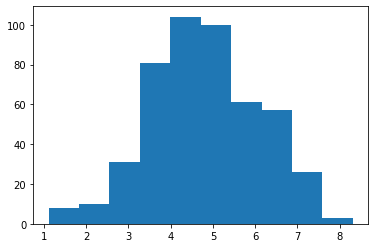

In [134]:
plot_hist(grp_B_T3_M_time_trans)

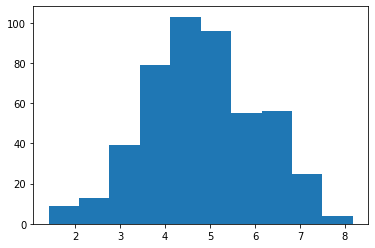

In [135]:
plot_hist(grp_B_T3_M_time_trans_rem)

## Distfit

In [136]:
dist1 = distfit(alpha=0.05, stats='RSS')
dist1.fit_transform(group_B_T3_M['time'],verbose=1)

{'model': {'distr': <scipy.stats._continuous_distns.genextreme_gen at 0x1c1a2aa4760>,
  'stats': 'RSS',
  'params': (-0.7293291901187826, 64.59953610854959, 64.76052387079699),
  'name': 'genextreme',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c1a7ae73a0>,
  'score': 1.2747934900587298e-06,
  'loc': 64.59953610854959,
  'scale': 64.76052387079699,
  'arg': (-0.7293291901187826,),
  'CII_min_alpha': 15.69445161119593,
  'CII_max_alpha': 750.5827877646492},
 'summary':          distr     score  LLE            loc         scale  \
 0   genextreme  0.000001  NaN      64.599536     64.760524   
 1      lognorm  0.000002  NaN      -0.609725     97.944277   
 2         beta  0.000005  NaN            3.0  39569.558732   
 3        expon  0.000006  NaN            3.0    180.760915   
 4            t  0.000011  NaN      74.834709      53.85191   
 5       pareto  0.000021  NaN      -0.004222      3.004222   
 6         norm  0.000045  NaN     183.760915    242.462418   
 7    

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\ngenextreme\nc=-0.729329, loc=64.5995, scale=64.7605'}, xlabel='Values', ylabel='Frequency'>)

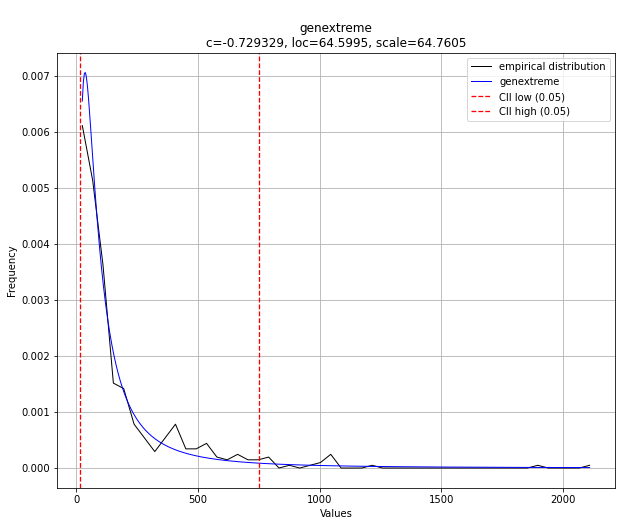

In [137]:
dist1.plot(verbose=1)

In [138]:
dist1.summary

,distr,score,LLE,loc,scale,arg
0,genextreme,0.000001,NaN,64.599536,64.760524,"(-0.7293291901187826,)"
1,lognorm,0.000002,NaN,-0.609725,97.944277,"(1.1485981875189482,)"
2,beta,0.000005,NaN,3.0,39569.558732,"(0.8708915238288715, 191.4866052268438)"
3,expon,0.000006,NaN,3.0,180.760915,()
4,t,0.000011,NaN,74.834709,53.85191,"(1.0451818096874539,)"
5,pareto,0.000021,NaN,-0.004222,3.004222,"(0.28804977733710413,)"
6,norm,0.000045,NaN,183.760915,242.462418,()
7,loggamma,0.000046,NaN,-114957.338688,14268.116211,"(3197.4071382095026,)"
8,uniform,0.000073,NaN,3.0,2127.0,()
9,gamma,0.000079,NaN,3.0,12.277896,"(0.04319185047810349,)"


[distfit] >plot summary..


(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Best fit: genextreme'}, xlabel='Distribution name', ylabel='RSS (lower is better)'>)

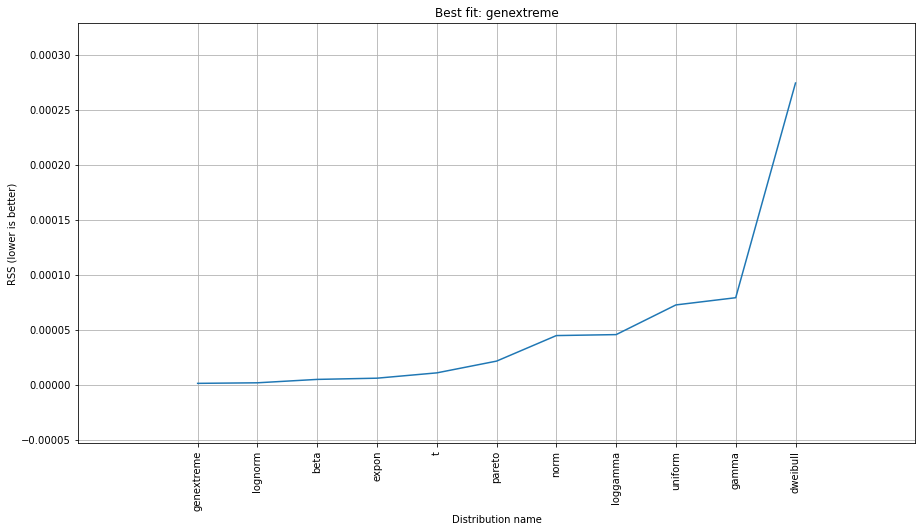

In [139]:
dist1.plot_summary()

## 